# Trajectory Optimization
The goal is to find u(t) which is the control input, force or torque.
Many methods, computes (directly or indirectly) states as function of time as well, x(t):   
    
<img src="./share/trajopt.png" alt="drawing" width="600">

We can solve the problem closed loop, meaning find a global optimal policy that outputs an action for each given state. But that is a hard solution to find. Value-iteraiton in Reinforcement Learning does that, or analytical solution to the dynamic problem. Instead we want to find only one trajectory that for a given intial state is going to reach to the goal. This is not gauranteed to be an global optimal solution and may get trapped in local minima.     

<img src="./share/closedloop.png"  width="600">

So a general trajectory optimization proble looks like the following picture:   
    
<img src="./share/general.png" alt="drawing" width="600">

# Transcription
So it is hard to do optimization over function $x(t)$ and $u(t)$. What we want to do is to convert that to a set of decision variables. So instead of having $u(t)$, we will have $u_1, u_2 ... u_n$ varaibles that we want to optimize over. Note that do not confuse this with discretizing time. We are not saying we are going from continous time to discrete time. We are saying we are defining some variables along trajectory at specific time.

<img src="./share/transcription.png" alt="drawing" width="400">

Shooting methods: 
- based on simulation
- problems with simple controls and no path constraints
        
Collocaiton methods:
- based on function approximation
- problem with complicated contrl and/or path constraints

# Direct Transcription
<img src="./share/direct_transcription.png" alt="drawing" width="800">

One method here, is to represent what happens between collocation points as linear. In bot dynamics and cost funciton.      

<img src="./share/trapezoid.png" alt="drawing" width="800">

And for dynamics:       
<img src="./share/trapezoid_dynamics.png" alt="drawing" width="800">
<img src="./share/trapezoid2.png" alt="drawing" width="400">

So all in all we can write the optimization problem as a direct collocation:     

<img src="./share/total.png"  width="800">


Some ideas to how find a good intial solution. Do the following options and solve to get a solution for a simpler problem, then use that to feed into the main problem as the initial guess.
- Remove dynamics constraint 
- Smaller number of grid points and solve.
- Use a simpler const function
- Remove difficult constratints

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, display

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    LeafSystem,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    SceneGraph,
    SnoptSolver,
    Solve,
    TrajectorySource,
    MathematicalProgram,
    MakeVectorVariable,
    Variable,
    ConstantVectorSource,
    SnoptSolver,
    SolverOptions,
    SolverType
)

from pydrake.examples import AcrobotGeometry, AcrobotPlant, PendulumPlant, PendulumState
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from IPython.core.display import Image, display
from underactuated.pendulum import PendulumVisualizer

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


### Direct Collocation for the Pendulum

using DirecCallocation() from Drake

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]
[0. 0.]
[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)
 Variable('x(4)', Continuous) Variable('x(5)', Continuous)
 Variable('x(6)', Continuous) Variable('x(7)', Continuous)
 Variable('x(8)', Continuous) Variable('x(9)', Continuous)
 Variable('x(10)', Continuous) Variable('x(11)', Continuous)
 Variable('x(12)', Continuous) Variable('x(13)', Continuous)
 Variable('x(14)', Continuous) Variable('x(15)', Continuous)
 Variable('x(16)', Continuous) Variable('x(17)', Continuous)
 Variable('x(18)', Continuous) Variable('x(19)', Continuous)
 Variable('x(20)', Continuous) Variable('x(21)', Continuous)
 Variable('x(22)', Continuous) Variable('x(23)', Continuous)
 Variable('x(24)', Continuous) Variable('x(25)', Continuous)
 Variable('x(26)', Continuous) Variable('x(27)', Continuous)
 Variable('x(28)', Continuous) Variable('x(29)', Continuous)
 Variable('x(30)', Continuo

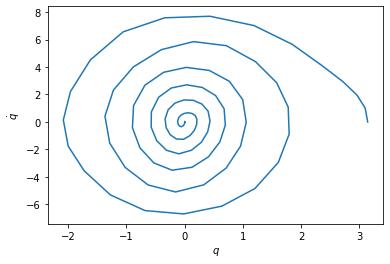

None

In [12]:
def pend_dircol():
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()

    N = 21
    max_dt = 0.5
    N * max_dt
    dircol = DirectCollocation(
        plant, # we do not have to explicitly set the dynamics as constraints. It does it by itself here
        context,
        num_time_samples=N,
        minimum_time_step=0.05,
        maximum_time_step=max_dt,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = 3.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = PendulumState()
    print(dircol.initial_state())
    print(initial_state.get_value())
    initial_state.set_theta(0.0)
    initial_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        initial_state.get_value(),
        initial_state.get_value(),
        dircol.initial_state(),
    )
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(
    #     dircol.initial_state() == initial_state.get_value())

    final_state = PendulumState()
    final_state.set_theta(np.pi)
    final_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        final_state.get_value(), final_state.get_value(), dircol.final_state()
    )
    # dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0] ** 2)

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], [initial_state.get_value(), final_state.get_value()]
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    print(prog.decision_variables())

    result = Solve(prog)
    assert result.is_success()
    print(result.GetSolution())
    print("solution input:", dircol.GetInputSamples(result))

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    print(dircol.GetSampleTimes(result))
    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )

    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # Animate the result.
    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_trajectory)
    display(HTML(ani.to_jshtml()))


pend_dircol()

Without using DirectCollocation     
$cost = \int u^2 \approx \Sigma \frac{u_i^2 + u_{i+1}^2}{2} h$      
        
s.t. $~~~ x_{k+1} = x_{k} + \frac{f_k+f_{k+1}}{2} h$

Equation of motion:     
$$I \ddot{q} + C \dot{q} = \tau_g + u $$     
$m = 1.0 \\
l  = 0.5 \space (length) \\
c = 0.1 \space (damping) \\ 
g = 9.81 \space (gravity) \\
$      

$$ml^2 \ddot{q} + c \dot{q} = -mgl \sin{q}  + u => \ddot{q} = (-0.1 \dot{q} -  4.905 \sin{q} + u) /0.25  $$ 

Expand on dynamic constraint:   
$x = \left[
    \begin{array}c
        q \\
        \dot{q} 
    \end{array}
    \right]$          
$\dot{x} = \left[
    \begin{array}c
        \dot{q} \\
        \ddot{q}
    \end{array} 
    \right] = f$         
so $f$ as the dynamics of the system is a vector with first element of $\dot{q}$ and second element of $\ddot{q}$ which is the forward dynamics from the equation of motions        
$f = \left[
    \begin{array}c
        \dot{q} \\
        (-0.1 \dot{q} -  4.905 \sin{q} + u) /0.25 
    \end{array} 
    \right]$            
And the constraint becomes:     
$q_{k+1} = q_{k} + (f_k[0] + f_{k+1}[0]) / 2 h $        
$\dot{q}_{k+1} = \dot{q}_{k} + (f_k[1] + f_{k+1}[1]) / 2 h $




generalized position  [0.1, 0.2]
[PendulumParams([1.0, 0.5, 0.1, 9.81])]
num of input ports InputPort[0] (tau) of System ::_ (PendulumPlant<double>)
[-2.0387316346107687]
[<Expression "q">, <Expression "v">]
compare this with the eq of motion in the description:
 [<Expression "v">, <Expression "(( - 0.10000000000000001 * v - 4.9050000000000002 * sin(q)) / 0.25)">]
True
optimal cost value:  7.784301582336168
solution:
 [ 0.4         0.35446014  0.18307385 -0.10963563 -0.46786052 -0.81203703
 -1.0608879  -1.14761199 -1.02547759 -0.67408832 -0.12158288  0.54357145
  1.21001278  1.79387431  2.25813723  2.60549615  2.85618721  3.02674861
  3.11747184  3.14159265  0.1        -1.01079728 -2.41692846 -3.43726105
 -3.72723678 -3.15629349 -1.82072387  0.08624211  2.35644588  4.67133951
  6.37876922  6.92431741  6.40450917  5.27272138  4.01253705  2.93464147
  2.07917967  1.33204836  0.48241623  0.          0.1        -2.1325216
 -2.64548975 -2.68530874 -2.22975164 -1.37544126 -0.28495387  0.8929

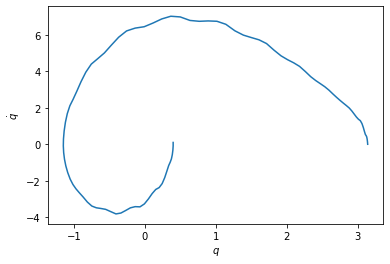

None

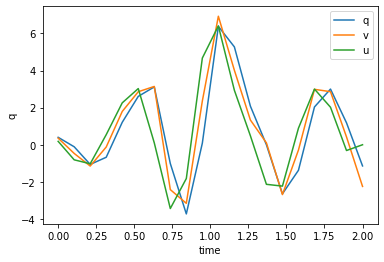

None

In [35]:
def pend_direct_collocation(use_direct_collocation, N, h, torque_limit):
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()
    context.SetContinuousState([0.1,0.2])
    print("generalized position ", plant.get_state(context))
    params = context.get_parameters()
    print(params.get_numeric_parameters().get_data())
    print("num of input ports", plant.get_input_port().GetFullDescription() )

    # plant.CalcTimeDerivatives()
    dervs = plant.EvalTimeDerivatives(context)
    print(dervs.get_generalized_velocity())

    q = Variable("q")
    v = Variable("v")
    # you can do a vector of them like:
    # MakeVectorVariable(num, "q")

    sym_plant = plant.ToSymbolic()
    sym_context = sym_plant.CreateDefaultContext()
    sym_context.SetContinuousState([q,v])
    print(sym_context.get_continuous_state_vector())

    # derivative of state give the equation of motion
    sym_dervs = sym_plant.EvalTimeDerivatives(sym_context)
    print('compare this with the eq of motion in the description:\n', sym_dervs.get_vector())

    prog = MathematicalProgram()
    # decision variables: [q , qdot, u]
    x = prog.NewContinuousVariables(3*(N)) 
    initial_state = [x[0], x[N], x[2*N]]
    final_state = [x[N-1], x[2*N-1], x[3*N-1]]

    # cost is on u, which start at x[20]
    cost = 0.0 
    for i in range(N-1):
        if use_direct_collocation:
            cost += (x[2*N + (i)]**2 + x[2*N + (i + 1)]**2) / 2 * h
        else:
            cost += x[2*N + i]**2
    prog.AddCost(cost)

    initial_state_val = [0.4, 0.1, 0.1]
    prog.AddBoundingBoxConstraint(
        initial_state_val,
        initial_state_val,
        initial_state,
    )
    final_state_val = [np.pi, 0.0, 0.0]
    prog.AddBoundingBoxConstraint(
        final_state_val, 
        final_state_val, 
        final_state
    )

    # we already added constraints on initial and final state, this is constratint in between
    for i in range(1,N-1):
        # input limit
        prog.AddConstraint(-torque_limit <= x[2*N + i])
        prog.AddConstraint(x[2*N + i] <= torque_limit)

    # We need one context per point.
    ctx_ = []
    import copy
    for i in range(0,N):
        ctx = copy.deepcopy(sym_context)
        ctx.SetContinuousState([x[i], x[N + i]])
        ctx_.append(ctx)

    # dynamics constraint per segment
    for i in range(0, N-1):
        Fcurrent = sym_plant.EvalTimeDerivatives(ctx_[i])
        Fnext = sym_plant.EvalTimeDerivatives(ctx_[i+1])
        if use_direct_collocation:
            # direc collocation: we use trapezoid method for collocation
            # the result of EvalTimeDerivatives is [qdot, qddot]
            prog.AddConstraint(x[i+1] == x[i] + (Fnext[0] + Fcurrent[0]) / 2 * h)
            # prog.AddConstraint(x[N+i+1] == x[N+i] + (Fnext[1] + Fcurrent[1]) / 2 * h)
            # i do not see the input, u in the derivaties, so I am adding them here manually
            # ... + x[2*N+i]/0.25 + ... + x[2*N+i+1]/0.25
            prog.AddConstraint(x[N+i+1] == x[N+i] + (Fcurrent[1] + x[2*N+i]/0.25 + Fnext[1] + x[2*N+i+1]/0.25) / 2 * h)
        
        else: 
            # direct transcription: we just pass the dynamics equation at knot points
            prog.AddConstraint(x[i+1] == x[i] + (h * Fcurrent[0])   )
            prog.AddConstraint(x[N+i+1] == x[N+i] + (Fcurrent[1] + x[2*N+i]/0.25) * h)

    # prog.SetSolverOption(SolverType.kSnopt, "Major iterations limit", 10000)
    # prog.SetSolverOption(SolverType.kSnopt, "Function precision", 1e-3)
    result = Solve(prog)
    # solver = SnoptSolver()
    # solver_options = SolverOptions()
    # result = solver.Solve(prog, None, solver_options)

    print(result.is_success())
    print('optimal cost value: ', result.get_optimal_cost())
    solution = result.GetSolution()
    print('solution:\n', solution)
    print('solution shape', solution.shape)

    # Animate the result.
    times = np.linspace(0,N*h,N)
    num_states = 2
    states = np.zeros((num_states, N))
    derivatives = np.zeros((num_states, N))
    for i in range(N):
        states[:,i] = result.GetSolution([x[i],x[N+i]]) 
        # if (input_port) {
        # input_port_value->GetMutableVectorData<double>()->SetFromVector(
        #     result.GetSolution(input(i)));
        # }
        context.SetContinuousState(states[:,i])
        derivatives[:,i] = plant.EvalTimeDerivatives(context).CopyToVector() 

    x_traj = PiecewisePolynomial.CubicHermite(
            breaks=times, samples=states, samples_dot=derivatives)

    fig, ax = plt.subplots()
    x_knots = np.hstack(
        [
            x_traj.value(t)
            for t in np.linspace(
                x_traj.start_time(), x_traj.end_time(), 100
            )
        ]
    )

    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    plt.figure()
    plt.plot(times, solution.reshape(N,3), label=["q","v","u"])
    plt.xlabel("time")
    plt.ylabel("q")
    plt.legend()
    display(plt.show())

    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_traj)
    display(HTML(ani.to_jshtml()))

# N points with N-1 segments
N = 20 
# time interval
h = 0.1 # we can make this variable as well
torque_limit = 3.0  # N*m.
use_direct_collocation = True
# [True, 10, 0.5, 3.0] gives reasonable result but if we want to use direct_transcription, then h should be small to have good result.
pend_direct_collocation(use_direct_collocation, N, h, torque_limit)